# Implied Volatility of Index Options

In the article below, we will calculate the Implied Volatility of Future (Monthly) Options on the Index .STOXX50E (EURO STOXX 50 EUR PRICE INDEX) ('[EUREX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TVE9YWDUwJnN0PVJJQw%3D%3D&title=.STOXX50%20OV&key=bUq%2BNCiQGAcHQjSNEkJSlZLTgjo9cios8rz4heIBiU8%3D)').

In [1]:
x = 15

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC
3,Eurex Dow Jones EURO STOXX 50 Index Option 342...,STXE34250K2.EX,3425,EUX,2022-11-18,[.STOXX50E]


.STOXX50E data frame:


,TRDPRC_1
Timestamp,
2022-10-14 13:30:00,3452.99
2022-10-14 13:40:00,3429.03


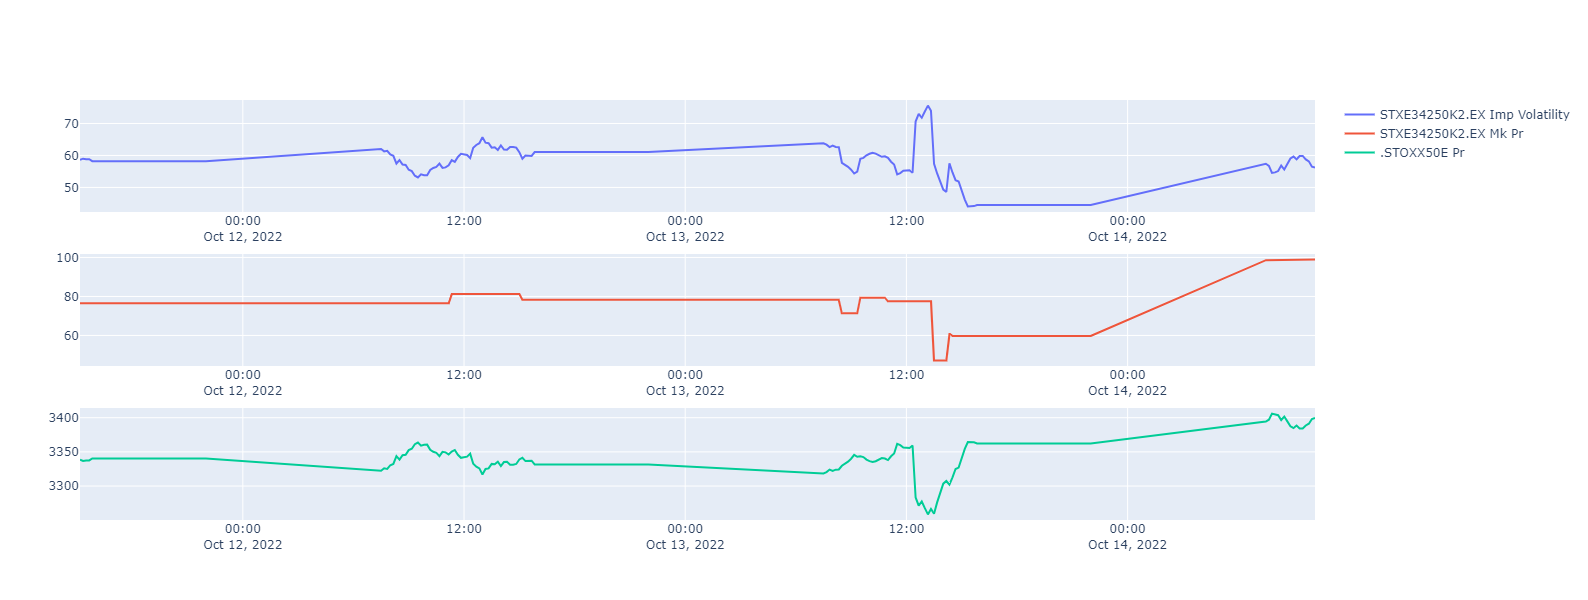

In [45]:
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing
from refinitiv.data.content.historical_pricing import Intervals
from refinitiv.data.content.historical_pricing import Adjustments
from refinitiv.data.content.historical_pricing import MarketSession
from refinitiv.data.content import search

import numpy as np
import pandas as pd
import calendar
import pandas_market_calendars as mcal  # See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px # This is just to see the implied vol graph when that field is available

rd.open_session()



def get_exp_dates(year, days=True, mcal_get_calendar='EUREX'):
    '''
    get_exp_dates Version 2.0:

    This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand chaned Haykaz Aramyan's original code to allow
        (i) for the function's holiday argument to be changed, and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
        (ii) for the function to output full date objects as opposed to just days of the month if agument days=True.

    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version 3.2

    Parameters
    -----------------------------------------------
    Input:
        year(int): year for which expiration days are requested

        mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github chacked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
            Default: mcal_get_calendar='EUREX'

        days(bool): If True, only days of the month is outputed, else it's dataeime objects
            Default: days=True

    Output:
        dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
    '''

    # get CBOE market holidays
    EUREXCal = mcal.get_calendar(mcal_get_calendar)
    holidays = EUREXCal.holidays().holidays

    # set calendar starting from Saturday
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)

    # get the 3rd Friday of each month
    exp_dates = {}
    for i in range(1, 13):
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        # check if found date is an holiday and get the previous date if it is
        if date in holidays:
            date = date + timedelta(-1)
        # append the date to the dictionary
        if year in exp_dates:
            ### Changed from original code from here on by Jonathan Legrand on 2022-10-11
            if days: exp_dates[year].append(date.day)
            else: exp_dates[year].append(date)
        else:
            if days: exp_dates[year] = [date.day]
            else: exp_dates[year] = [date]
    return exp_dates



timeOfCalcDatetime = datetime.now()  # For now, we will focuss on the use-case where we are calculating values for today; later we will allow for it historically for any day going back a few business days.
timeOfCalcStr = datetime.now().strftime('%Y-%m-%d')

fullDatesAtTimeOfCalc = get_exp_dates(timeOfCalcDatetime.year, days=False) # `timeOfCalcDatetime.year` here is 2022
fullDatesAtTimeOfCalcDatetime = [
    datetime(i.year, i.month, i.day)
    for i in fullDatesAtTimeOfCalc[list(fullDatesAtTimeOfCalc.keys())[0]]]




expiryDateOfInt = [i for i in fullDatesAtTimeOfCalcDatetime
                   if i > timeOfCalcDatetime + relativedelta(days=x)][0]



response2 = search.Definition(
    view = search.Views.SEARCH_ALL, # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
    query=".STOXX50E",
    select="DocumentTitle, RIC, StrikePrice, ExchangeCode, ExpiryDate, UnderlyingAsset, " +
            "UnderlyingAssetName, UnderlyingAssetRIC, ESMAUnderlyingIndexCode, RCSUnderlyingMarket" +
            "UnderlyingQuoteName, UnderlyingQuoteRIC",
    filter="RCSAssetCategoryLeaf eq 'Option' and RIC eq 'STX*' and DocumentTitle ne '*Weekly*' " +
    "and CallPutOption eq 'Call' and ExchangeCode eq 'EUX' and " +
    f"ExpiryDate ge {(expiryDateOfInt - relativedelta(days=1)).strftime('%Y-%m-%d')} " +
    f"and ExpiryDate lt {(expiryDateOfInt + relativedelta(days=1)).strftime('%Y-%m-%d')}",  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
    top=10000,
).get_data()
searchDf2 = response2.data.df

currentUnderlyingPrc = rd.get_history(
    universe=[searchDf2.UnderlyingQuoteRIC[0][0]],
    fields=["TRDPRC_1"],
    interval="tick").iloc[-1][0]
display(searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]])



instrument = searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]].RIC.values[0]



start = (timeOfCalcDatetime - pd.tseries.offsets.BDay(3)).strftime('%Y-%m-%dT%H:%M:%S.%f')  # '2022-10-05T07:30:00.000'
end = (datetime.now() - timedelta(minutes=0)).strftime('%Y-%m-%dT%H:%M:%S.%f') #  '2022-09-09T20:00:00.000'



_optnMrktPrice = rd.get_history(
    universe=[instrument],
    fields=["TRDPRC_1"],
    interval="10min",
    start=start,  # Ought to always start at 4 am for OPRA exchanged Options, more info in the article below
    end=end)  # Ought to always end at 8 pm for OPRA exchanged Options, more info in the article below



optnMrktPrice = _optnMrktPrice.resample('10Min').mean() # get a datapoint every 10 min
optnMrktPrice = optnMrktPrice[optnMrktPrice.index.strftime('%Y-%m-%d').isin([i for i in _optnMrktPrice.index.strftime('%Y-%m-%d').unique()])]  # Only keep trading days
optnMrktPrice = optnMrktPrice.loc[(optnMrktPrice.index.strftime('%H:%M:%S') >= '07:30:00') & (optnMrktPrice.index.strftime('%H:%M:%S') <= '22:00:00')]  # Only keep trading hours
optnMrktPrice.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values



underlying = searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]].UnderlyingQuoteRIC.values[0][0]



_underlyingMrktPrice = rd.get_history(
    universe=[underlying],
    fields=["TRDPRC_1"],
    interval="10min",
    start=start,
    end=end)
print(f"{underlying} data frame:")
display(_underlyingMrktPrice.iloc[-2:])



df = optnMrktPrice.copy()
df['underlying ' + underlying + ' TRDPRC_1'] = _underlyingMrktPrice
df.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
df = df.dropna()



K = searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]].StrikePrice.values[0]



_EurRfRate = rd.get_history(
    universe=['EURIBOR3MD='],  # USD3MFSR=, USDSOFR=
    fields=['TR.FIXINGVALUE'],
    # Since we will use `dropna()` as a way to select the rows we are after later on in the code, we need to ask for more risk-free data than needed, just in case we don't have enough:
    start=(datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - timedelta(days=1)).strftime('%Y-%m-%d'),
    end=(datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%f') + timedelta(days=1)).strftime('%Y-%m-%d'))



EurRfRate = _EurRfRate.resample('10Min').mean().fillna(method='ffill')
df['EurRfRate'] = EurRfRate
df = df.fillna(method='ffill')



request_definition = rd.delivery.endpoint_request.Definition(
    method = rd.delivery.endpoint_request.RequestMethod.POST,
    url = 'https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
    body_parameters={
    "fields": [
    "MarketValueInDealCcy",
    "RiskFreeRatePercent",
    "UnderlyingPrice",
    "PricingModelType",
    "DividendType",
    "VolatilityType",
    "UnderlyingTimeStamp",
    "ReportCcy",
    "VolatilityType",
    "Volatility",
    "DeltaPercent",
    "GammaPercent",
    "RhoPercent",
    "ThetaPercent",
    "VegaPercent"
  ],
  "outputs": [
    "Data",
    "Headers"
  ],
  "universe": [
        {
          "instrumentType": "Option",
          "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": "STXE35500J2.EX",
            "strike": str(K),
          },
          "pricingParameters": {
            "marketValueInDealCcy": str(df['TRDPRC_1'][i]),
            "riskFreeRatePercent": str(df['EurRfRate'][i]),
            "underlyingPrice": str(df['underlying ' + underlying + ' TRDPRC_1'][i]),
            "pricingModelType": "BlackScholes",
            "dividendType": "ImpliedYield",
            "volatilityType": "Implied",
            "underlyingTimeStamp": "Default",
            "reportCcy": "EUR"
          }
        }
      for i in range(len(df.index))]
}
)

response3 = request_definition.get_data()
headers_name = [h['name'] for h in response3.data.raw['headers']]
response3df = pd.DataFrame(data=response3.data.raw['data'], columns=headers_name)



IPADf = response3df.copy()
IPADf.index = df.index
IPADf.columns.name = df.columns.name



fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.Volatility, name=instrument + ' Imp Volatility'), row=1, col=1)
fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.MarketValueInDealCcy, name=instrument + ' Mk Pr'), row=2, col=1)
fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.UnderlyingPrice, name=underlying + ' Pr'), row=3, col=1)


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(title=IPADf.columns.name)
fig.update_layout(
    autosize=False,
    # width=1400,
    height=600)
fig.show()